# 1 - Imports

In [1]:
# Snowpark Imports
from snowflake.snowpark import Session
from snowflake.snowpark.context import get_active_session
import snowflake.snowpark.functions as F
from snowflake.snowpark.exceptions import SnowparkSessionException
from snowflake.snowpark.functions import sproc
from snowflake.snowpark import types as T

# Snowpark ML
from snowflake.ml.modeling.impute import SimpleImputer
from snowflake.ml.modeling.preprocessing import OrdinalEncoder, OneHotEncoder
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error
from snowflake.ml.registry import Registry
from snowflake.ml.feature_store import FeatureStore, FeatureView, Entity, CreationMode

# Snowflake Task API
from snowflake.core import Root
from snowflake.core.database import Database
from snowflake.core.schema import Schema
from snowflake.core.warehouse import Warehouse
from snowflake.core import Root
from snowflake.core.task import StoredProcedureCall
from snowflake.core.task.dagv1 import DAG, DAGTask, DAGOperation
from snowflake.core._common import CreateMode

# Other Imports
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from demo_data import generate_demo_data
from plotting import plot_evidently_results, plot_model_metrics

#
import warnings
warnings.filterwarnings("ignore")

# 2 - Create or Retrieve Session

In [2]:
try:
    # Get active session if running in Snowflake Notebook
    session = get_active_session()
except SnowparkSessionException:
    # Create a new session via .env file if running externally
    import os
    from dotenv import load_dotenv
    load_dotenv()
    snowflake_connection_cfg = {
        "ACCOUNT": os.getenv('SF_ACCOUNT'),
        "USER": os.getenv('SF_USER'),
        "ROLE": os.getenv('SF_ROLE'),
        "PASSWORD": os.getenv('SF_PASSWORD'),
    }

    # Creating Snowpark Session
    session = Session.builder.configs(snowflake_connection_cfg).create()

# 3 - Set Up Environment

In [3]:
# Create Database & Schema
root = Root(session)
ml_demo_db = Database(name="SIMPLE_ML_DB")
ml_demo_db = root.databases.create(ml_demo_db, mode='or_replace')
ml_demo_schema = Schema(name="SIMPLE_ML_SCHEMA")
ml_demo_schema = ml_demo_db.schemas.create(ml_demo_schema, mode='or_replace')

# Create warehouse
ml_wh = Warehouse(name="ML_WH", warehouse_size="XSMALL", auto_suspend=600, auto_resume='true')
warehouses = root.warehouses
ml_wh = warehouses.create(ml_wh)

# Set context
session.use_schema('SIMPLE_ML_DB.SIMPLE_ML_SCHEMA')
session.use_warehouse('ML_WH')

# Create Feature Store
fs = FeatureStore(
    session=session, 
    database="SIMPLE_ML_DB", 
    name="SIMPLE_ML_SCHEMA", 
    default_warehouse="COMPUTE_WH",
    creation_mode=CreationMode.CREATE_IF_NOT_EXIST,
)

# 4 - Create Demo Data

In [ ]:
# We create three tables: 
# 1. Customer Life Time Value a.k.a Money spent with us (Email, Spent Money)
# 2. General Customer Data (Email, Gender, Membership Status, Join Date)
# 3. Customer Behaviour Data (Average Session Length, Average Time on App, Average Time on Website)

In [4]:
generate_demo_data(session, month=4)

Added 1000 customers to table: CUSTOMER_LIFE_TIME_VALUE
Added 1000 customers to table: CUSTOMER_GENERAL_DATA
Added 1000 customers to table: CUSTOMER_BEHAVIOR_DATA


# 5 - Data Exploration

In [5]:
# Create a Snowpark DataFrames
print('Customer Life Time Value Data:')
ltv_df = session.table('CUSTOMER_LIFE_TIME_VALUE').drop('MONTH')
ltv_df.show(n=2)

print('Customer General Data:')
cust_df = session.table('CUSTOMER_GENERAL_DATA')
cust_df.show(n=2)

print('Customer Behavior Data:')
behavior_df = session.table('CUSTOMER_BEHAVIOR_DATA')
behavior_df.show(n=2)

Customer Life Time Value Data:
--------------------------------------------
|"EMAIL"               |"LIFE_TIME_VALUE"  |
--------------------------------------------
|1fzRBt8ATy@a4eaR.com  |113.60             |
|IbIhHT5h5F@qnwHw.com  |514.27             |
--------------------------------------------

Customer General Data:
------------------------------------------------------------------------------
|"EMAIL"               |"GENDER"  |"MEMBERSHIP_STATUS"  |"MEMBER_JOIN_DATE"  |
------------------------------------------------------------------------------
|1fzRBt8ATy@a4eaR.com  |FEMALE    |BASIC                |2024-04-21          |
|IbIhHT5h5F@qnwHw.com  |MALE      |GOLD                 |2024-04-03          |
------------------------------------------------------------------------------

Customer Behavior Data:
-------------------------------------------------------------------------------------------------------
|"EMAIL"               |"AVG_SESSION_LENGTH_MIN"  |"AVG_TIME_ON_APP_MIN"

In [6]:
# Describe data using various statistics
print('Statistical Data Analysis:')
ltv_df.describe().show()
cust_df.describe().show()
behavior_df.describe().show()

Statistical Data Analysis:
---------------------------------------------------------
|"SUMMARY"  |"EMAIL"               |"LIFE_TIME_VALUE"   |
---------------------------------------------------------
|count      |1000                  |1000.0              |
|mean       |NULL                  |385.63942           |
|stddev     |NULL                  |213.31221531986466  |
|min        |00FBMsJJ6s@Jyaag.com  |1.21                |
|max        |zwVs04Xwxx@ZkAHa.com  |748.64              |
---------------------------------------------------------

---------------------------------------------------------------------
|"SUMMARY"  |"EMAIL"               |"GENDER"  |"MEMBERSHIP_STATUS"  |
---------------------------------------------------------------------
|count      |1000                  |1000      |1000                 |
|mean       |NULL                  |NULL      |NULL                 |
|stddev     |NULL                  |NULL      |NULL                 |
|min        |00FBMsJJ6s@Jyaag.

# 6 - Feature Engineering

In [7]:
# Create a new entity for the Feature Store
entity = Entity(name="EMAIL", join_keys=["EMAIL"], desc='Unique identifier for customers.')
fs.register_entity(entity)
fs.list_entities().show()

--------------------------------------------------------------------------
|"NAME"  |"JOIN_KEYS"  |"DESC"                            |"OWNER"       |
--------------------------------------------------------------------------
|EMAIL   |["EMAIL"]    |Unique identifier for customers.  |ACCOUNTADMIN  |
--------------------------------------------------------------------------



### Register Customer General Features

In [8]:
# Create a new Feature Definition that captures the number of days since joining 
cust_feature_df = cust_df.with_column('MEMBERSHIP_LENGTH_DAYS', F.current_date()-F.col('MEMBER_JOIN_DATE'))
cust_feature_df.show(n=3)

---------------------------------------------------------------------------------------------------------
|"EMAIL"               |"GENDER"  |"MEMBERSHIP_STATUS"  |"MEMBER_JOIN_DATE"  |"MEMBERSHIP_LENGTH_DAYS"  |
---------------------------------------------------------------------------------------------------------
|1fzRBt8ATy@a4eaR.com  |FEMALE    |BASIC                |2024-04-21          |59                        |
|IbIhHT5h5F@qnwHw.com  |MALE      |GOLD                 |2024-04-03          |77                        |
|QOTGLmIHFX@E0vay.com  |MALE      |PLATIN               |2024-04-01          |79                        |
---------------------------------------------------------------------------------------------------------



In [9]:
# Create Feature View
cust_fv = FeatureView(
    name="CUSTOMER_GENERAL_DATA_FEATURES", 
    entities=[entity],
    feature_df=cust_feature_df['EMAIL','GENDER','MEMBERSHIP_STATUS','MEMBERSHIP_LENGTH_DAYS'], 
    refresh_freq="1 minute",  # can also be a cron schedule - * * * * * America/Los_Angeles
    desc="Ecommerce Customer General Features")

# Add descriptions for some features
cust_fv = cust_fv.attach_feature_desc(
    {
        "GENDER":"Gender of the customer. Can be MALE or FEMALE.",
        "MEMBERSHIP_STATUS":"Membership Status of the customer. Can be Bronze, Silver, Gold, Platin or Diamond.",
        "MEMBERSHIP_LENGTH_DAYS":"Number of days since the customer joined the loyalty program. Calculated using the Join Date."
    }
)

cust_fv = fs.register_feature_view(
    feature_view=cust_fv, 
    version="V1", 
    block=True)

### Register Customer Behavior Features

In [10]:
# Create Feature View
behavior_fv = FeatureView(
    name="CUSTOMER_BEHAVIOR_DATA_FEATURES", 
    entities=[entity],
    feature_df=behavior_df['EMAIL','AVG_SESSION_LENGTH_MIN','AVG_TIME_ON_APP_MIN','AVG_TIME_ON_WEBSITE_MIN'], 
    refresh_freq="1 minute",  # can also be a cron schedule - * * * * * America/Los_Angeles
    desc="Ecommerce Customer Behavior Features")

# Add descriptions for some features
behavior_fv = behavior_fv.attach_feature_desc(
    {
        "AVG_SESSION_LENGTH_MIN":"Average Session Length in Minutes.",
        "AVG_TIME_ON_APP_MIN":"Average Time a customer spends in the app per day.",
        "AVG_TIME_ON_WEBSITE_MIN":"Average Time a customers spend on the website per day.",
    }
)

behavior_fv = fs.register_feature_view(
    feature_view=behavior_fv, 
    version="V1", 
    block=True)

### Generate a Training Dataset

In [11]:
registered_dataset = fs.generate_dataset(
    name="ECOMMERCE_CUSTOMER_FEATURES",
    spine_df=ltv_df,
    features=[cust_fv,behavior_fv],
    #version="V4",
    spine_label_cols=["LIFE_TIME_VALUE"],
    desc="Training Data to train model to predict Customer Life Time Value."
)

# Retrieve a Snowpark DataFrame from the registered Dataset
registered_dataset_df = registered_dataset.read.to_snowpark_dataframe()
registered_dataset_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EMAIL"               |"LIFE_TIME_VALUE"   |"GENDER"  |"MEMBERSHIP_STATUS"  |"MEMBERSHIP_LENGTH_DAYS"  |"AVG_SESSION_LENGTH_MIN"  |"AVG_TIME_ON_APP_MIN"  |"AVG_TIME_ON_WEBSITE_MIN"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1fzRBt8ATy@a4eaR.com  |113.5999984741211   |FEMALE    |BASIC                |59                        |2.135999917984009         |4.136000156402588      |4.136000156402588          |
|IbIhHT5h5F@qnwHw.com  |514.27001953125     |MALE      |GOLD                 |77                        |5.1427001953125           |8.1427001953125        |10.1427001953125           |
|QOTGLmIHFX@E0vay.com  |649.5999755859375   |MALE      |PLATIN             

# 7. Modelling

In [12]:
# Split the data into train and test sets
train_df, test_df = registered_dataset_df.random_split(weights=[0.9, 0.1], seed=0)
train_df.count(), test_df.count()

# Drop the Email column for Training
train_df = train_df.drop('EMAIL')

# Define sklearn-like Imputers
si_numeric =  SimpleImputer(
    input_cols=['AVG_SESSION_LENGTH_MIN','AVG_TIME_ON_APP_MIN','AVG_TIME_ON_WEBSITE_MIN'], 
    output_cols=['AVG_SESSION_LENGTH_MIN_IMP','AVG_TIME_ON_APP_MIN_IMP','AVG_TIME_ON_WEBSITE_MIN_IMP'],
    strategy='mean',
    drop_input_cols=False
)

# Define sklearn-like Encoders
categories = {
    "MEMBERSHIP_STATUS": np.array(["BASIC", "BRONZE", "SILVER", "GOLD", "PLATIN", "DIAMOND"]),
}
oe_categorical = OrdinalEncoder(
    input_cols=["MEMBERSHIP_STATUS"], 
    output_cols=["MEMBERSHIP_STATUS_OE"], 
    categories=categories,
    drop_input_cols=False
)

ohe_categorical = OneHotEncoder(
    input_cols=["GENDER"], 
    output_cols=["GENDER_OHE"],
    drop_input_cols=False
)

# Define the XGBoost model (incl. Hyperparameter Tuning)
feature_cols = [
    'GENDER_OHE_FEMALE',
    'GENDER_OHE_MALE',
    'MEMBERSHIP_STATUS_OE',
    'MEMBERSHIP_LENGTH_DAYS',
    'AVG_SESSION_LENGTH_MIN_IMP',
    'AVG_TIME_ON_APP_MIN_IMP',
    'AVG_TIME_ON_WEBSITE_MIN_IMP'
]
label_cols = ['LIFE_TIME_VALUE']
output_cols = ['LIFE_TIME_VALUE_PREDICTION']

grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators":[100, 200, 300, 400],
        "learning_rate":[0.1, 0.2, 0.3],
    },
    n_jobs = -1,
    scoring="neg_mean_absolute_percentage_error",
    input_cols=feature_cols,
    label_cols=label_cols,
    output_cols=output_cols
)

# Build the pipeline
model_pipeline = Pipeline(
    steps=[
        ("SI_NUMERIC",si_numeric),
        ("OE_CATEGORICAL",oe_categorical),
        ("OHE_CATEGORICAL",ohe_categorical),
        ("GRIDSEARCH_XGBOOST",grid_search)
    ]
)

# Fit the pipeline to the training data
fitted_pipeline = model_pipeline.fit(train_df)

# 8 - Model Evaluation

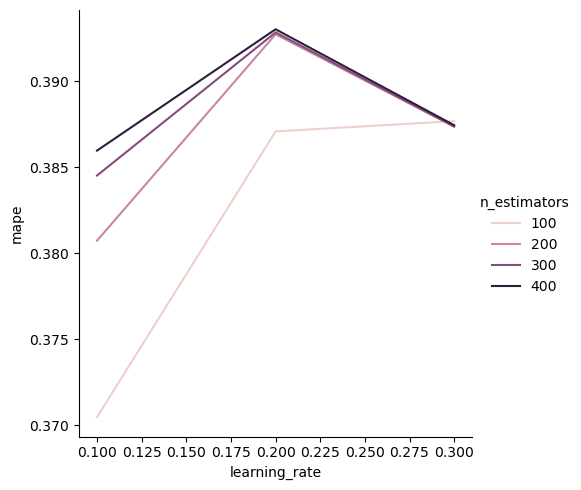

In [13]:
# Analyze grid search results
gs_results = fitted_pipeline.to_sklearn().named_steps['GRIDSEARCH_XGBOOST'].cv_results_
n_estimators_val = []
learning_rate_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    learning_rate_val.append(param_dict["learning_rate"])
mape_val = gs_results["mean_test_score"]*-1

gs_results_df = pd.DataFrame(data={
    "n_estimators":n_estimators_val,
    "learning_rate":learning_rate_val,
    "mape":mape_val})

sns.relplot(data=gs_results_df, x="learning_rate", y="mape", hue="n_estimators", kind="line")

plt.show()

-----------------------------------------------------
|"LIFE_TIME_VALUE"   |"LIFE_TIME_VALUE_PREDICTION"  |
-----------------------------------------------------
|696.8400268554688   |686.01708984375               |
|252.3300018310547   |247.95066833496094            |
|571.6300048828125   |585.7958374023438             |
|582.4600219726562   |589.985595703125              |
|129.33999633789062  |83.7649154663086              |
|302.2799987792969   |306.5988464355469             |
|446.5               |424.07623291015625            |
|12.829999923706055  |53.492393493652344            |
|260.6400146484375   |264.5618591308594             |
|742.1099853515625   |710.294921875                 |
-----------------------------------------------------

Mean absolute percentage error: 0.3360889345784607


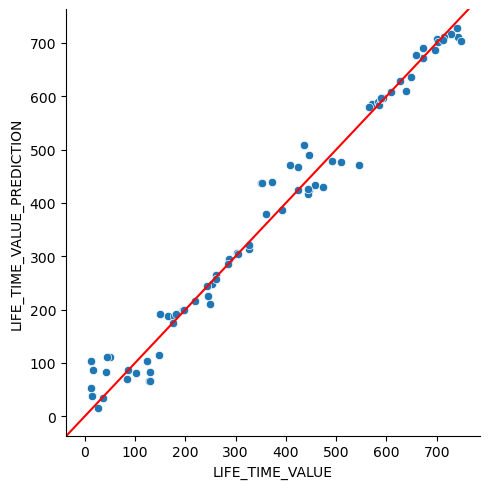

In [14]:
# Predict LTV for customers in test data
predictions = fitted_pipeline.predict(test_df)

# Analyze results
mape = mean_absolute_percentage_error(df=predictions, 
                                        y_true_col_names="LIFE_TIME_VALUE", 
                                        y_pred_col_names="LIFE_TIME_VALUE_PREDICTION")

predictions.select("LIFE_TIME_VALUE", "LIFE_TIME_VALUE_PREDICTION").show()
print(f"Mean absolute percentage error: {mape}")

# Plot actual vs predicted 
g = sns.relplot(
    data=predictions["LIFE_TIME_VALUE", "LIFE_TIME_VALUE_PREDICTION"].to_pandas().astype("float64"), 
    x="LIFE_TIME_VALUE", 
    y="LIFE_TIME_VALUE_PREDICTION", 
    kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

plt.show()

# 9 - Register & Run Model

In [15]:
# Create reference to model registry
reg = Registry(session=session, database_name=session.get_current_database(), schema_name=session.get_current_schema())

# Register new model version
registered_model = reg.log_model(
    fitted_pipeline,
    model_name="CUSTOMER_LTV_MODEL",
    comment="Model trained using GridsearchCV in Snowpark to predict Customer Life Time Value",
    metrics={"mean_abs_pct_err": mape},
    conda_dependencies=['xgboost']
)

In [18]:
# Generate new customers for year 2024
# We simulate that newer customers have 3X avg_session_length and try to detect this drift
generate_demo_data(session, month=5, num_customers=100, session_length_multiplier=3)

# Retrieve new customers
new_customers_df = session.table('CUSTOMER_LIFE_TIME_VALUE').filter(F.col('MONTH')==5).select('EMAIL')
new_customers_df.show()

------------------------
|"EMAIL"               |
------------------------
|a6qV1DjNWP@et10Y.com  |
|xeQwO42Kco@syuJj.com  |
|N7Ca7SOqKt@f4SHJ.com  |
|7wv2aR0TiA@nJdvv.com  |
|NDrDXfv2ZW@LwFX7.com  |
|RCFaY77WVy@DflAH.com  |
|zyaQ5PF6PK@8pjsY.com  |
|izfbtw4NBC@c4bN8.com  |
|BdB0kJP3RL@PtT3Z.com  |
|hPBGdISPH1@xFhmM.com  |
------------------------



In [19]:
# Retrieve features using the Spine DataFrame (can take up to a minute until values appear)
# Assumption is you only have the unique-id EMAIL and need to retrieve the features to score the model
new_customers_features = fs.retrieve_feature_values(new_customers_df, features=[cust_fv, behavior_fv])
new_customers_features.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EMAIL"               |"GENDER"  |"MEMBERSHIP_STATUS"  |"MEMBERSHIP_LENGTH_DAYS"  |"AVG_SESSION_LENGTH_MIN"  |"AVG_TIME_ON_APP_MIN"  |"AVG_TIME_ON_WEBSITE_MIN"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
|a6qV1DjNWP@et10Y.com  |FEMALE    |SILVER               |29                        |17.5722                   |9.5722                 |6.5722                     |
|7wv2aR0TiA@nJdvv.com  |MALE      |SILVER               |49                        |6.4416                    |8.4416                 |6.4416                     |
|NDrDXfv2ZW@LwFX7.com  |FEMALE    |GOLD                 |34                        |NULL                      |11.6506                |9.6506                     |
|zyaQ5PF6PK@8pjs

In [20]:
# Create predictions from registered model given the retrieved features
new_predictions = registered_model.run(new_customers_features, function_name='predict')
new_predictions.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EMAIL"               |"GENDER"  |"MEMBERSHIP_STATUS"  |"AVG_SESSION_LENGTH_MIN"  |"AVG_TIME_ON_APP_MIN"  |"AVG_TIME_ON_WEBSITE_MIN"  |"GENDER_OHE_FEMALE"  |"GENDER_OHE_MALE"  |"MEMBERSHIP_STATUS_OE"  |"MEMBERSHIP_LENGTH_DAYS"  |"AVG_SESSION_LENGTH_MIN_IMP"  |"AVG_TIME_ON_APP_MIN_IMP"  |"AVG_TIME_ON_WEBSITE_MIN_IMP"  |"LIFE_TIME_VALUE_PREDICTION"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### [OPTIONAL] Use the model via SQL

In [21]:
# Create a view that will be used in SQL to predict the target variable
new_customers_features.create_or_replace_temp_view('INFERENCE_TEST')

[Row(status='View INFERENCE_TEST successfully created.')]

In [22]:
# SQL Execution of the trained model
session.sql("""
    SELECT *, 
        CUSTOMER_LTV_MODEL!PREDICT(
            GENDER,
            MEMBERSHIP_STATUS,
            MEMBERSHIP_LENGTH_DAYS,
            AVG_SESSION_LENGTH_MIN,
            AVG_TIME_ON_APP_MIN,
            AVG_TIME_ON_WEBSITE_MIN)['LIFE_TIME_VALUE_PREDICTION'] AS LIFE_TIME_VALUE_PREDICTION
    FROM INFERENCE_TEST
""").show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EMAIL"               |"GENDER"  |"MEMBERSHIP_STATUS"  |"MEMBERSHIP_LENGTH_DAYS"  |"AVG_SESSION_LENGTH_MIN"  |"AVG_TIME_ON_APP_MIN"  |"AVG_TIME_ON_WEBSITE_MIN"  |"LIFE_TIME_VALUE_PREDICTION"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|7wv2aR0TiA@nJdvv.com  |MALE      |SILVER               |49                        |6.4416                    |8.4416                 |6.4416                     |3.231949462890625e+02         |
|NDrDXfv2ZW@LwFX7.com  |FEMALE    |GOLD                 |34                        |NULL                      |11.6506                |9.6506                     |4.710025329589844e+02         |
|hPBGdISPH1@xFhmM.com  |M

# 10 - Model Monitoring & Email Notifications

In [29]:
# Setup the Email Integration
session.sql("""
    CREATE OR REPLACE NOTIFICATION INTEGRATION my_email_int
    TYPE=EMAIL
    ENABLED=TRUE
    ALLOWED_RECIPIENTS=('michael.gorkow@snowflake.com');""").collect()

# Create a stage to store monitoring functions & results
session.sql('CREATE STAGE IF NOT EXISTS MONITORING DIRECTORY = (ENABLE = TRUE)').show()

---------------------------------------------------
|"status"                                         |
---------------------------------------------------
|MONITORING already exists, statement succeeded.  |
---------------------------------------------------



In [30]:
# Create a Stored Procedure to send emails
@sproc(name='email_alerts', 
       packages=['snowflake-snowpark-python'], 
       is_permanent=True, 
       replace=True,
       stage_location='@MONITORING', 
       session=session)
def email_alerts(session: Session, alert_count: int) -> T.Variant:
    session.sql(f"""CALL SYSTEM$SEND_EMAIL(
        'my_email_int',
        'michael.gorkow@snowflake.com',
        'Model Monitoring Alert',
        'Alerts Detected in IRIS_FEATURES$V1: {alert_count}');""").collect()    
    return ("Email Alerts Complete!")

In [31]:
predictions.write.save_as_table('REFERENCE_DATA', mode='overwrite')
new_predictions.write.save_as_table('CURRENT_DATA', mode='overwrite')

In [32]:
@F.sproc(session=session, name='evidently_monitor', stage_location='@MONITORING',  
       packages=['snowflake-snowpark-python', 'pandas', 'evidently', 'snowflake-ml-python'], 
       is_permanent=True, 
       replace=True)
def monitor_model(session: Session) -> dict:
    from evidently.test_preset import DataDriftTestPreset
    from evidently.test_suite import TestSuite
    from joblib import dump
    from json import dumps

    data_drift_columns = ['GENDER','MEMBERSHIP_STATUS','MEMBERSHIP_LENGTH_DAYS',
                          'AVG_SESSION_LENGTH_MIN','AVG_TIME_ON_APP_MIN',
                          'AVG_TIME_ON_WEBSITE_MIN']

    reference = session.table('REFERENCE_DATA').select(data_drift_columns).sample(n=1000).to_pandas()
    current = session.table('CURRENT_DATA').select(data_drift_columns).sample(n=1000).to_pandas()

    # Generate a report from Evidently's default capabilities
    report = TestSuite(tests=[DataDriftTestPreset(stattest="psi", stattest_threshold='1'),])
    report.run(reference_data=reference, current_data=current)
    report.save_html("/tmp/report.html")
    session.file.put("/tmp/report.html", '@MONITORING', auto_compress=False, overwrite=True)
    test_summary = report.as_dict()

    # Send an Email if any tests failed
    if test_summary['summary']['failed_tests'] > 0:
            session.sql(f"""CALL SYSTEM$SEND_EMAIL(
                        'my_email_int',
                        'michael.gorkow@snowflake.com',
                        'Model Monitoring Alert',
                        'Alerts Detected for Customer Lifetime Value Model: {test_summary['summary']['failed_tests']}');""").collect()
    return test_summary

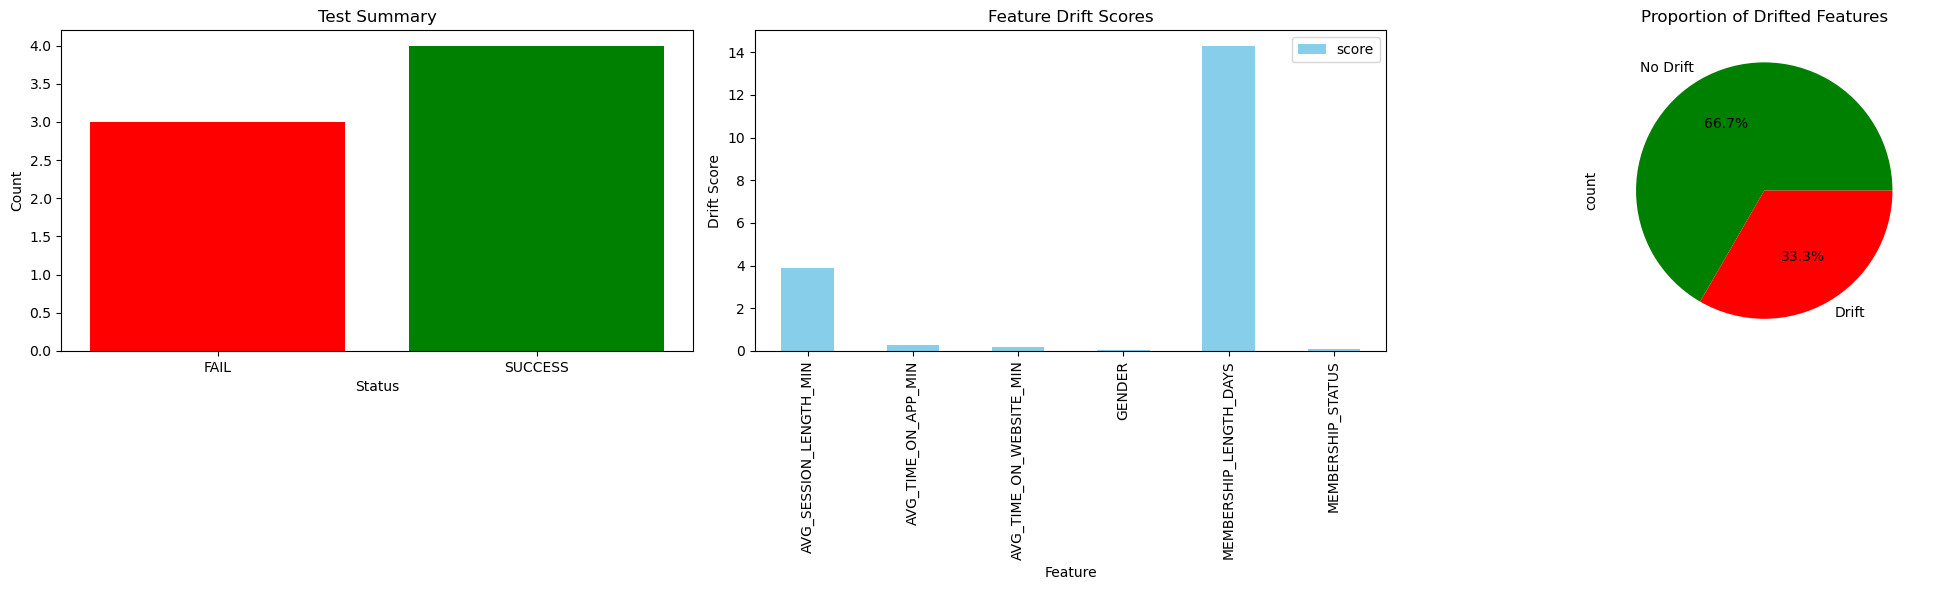

In [33]:
drift_detection_results = monitor_model(session)
drift_detection_results = json.loads(drift_detection_results)
drift_detection_results['summary']

# We can also visualize the results from the drift detection
plot_evidently_results(drift_detection_results)

# 11 - Automate Pipeline

In [34]:
# Create a new stage for the pipeline
session.sql("CREATE OR REPLACE STAGE DAG_STAGE").show()

----------------------------------------------
|"status"                                    |
----------------------------------------------
|Stage area DAG_STAGE successfully created.  |
----------------------------------------------



In [35]:
def train_model(session:Session) -> str:
    # Get spine dataframe
    ltv_df = session.table('CUSTOMER_LIFE_TIME_VALUE').drop('YEAR')

    # Reference Feature Store
    fs = FeatureStore(
        session=session, 
        database="SIMPLE_ML_DB", 
        name="SIMPLE_ML_SCHEMA", 
        default_warehouse="COMPUTE_WH",
    )
    # Generate Dataset
    registered_dataset = fs.generate_dataset(
        name="ECOMMERCE_CUSTOMER_FEATURES",
        spine_df=ltv_df,
        features=[
            fs.get_feature_view('CUSTOMER_GENERAL_DATA_FEATURES', version='V1'),
            fs.get_feature_view('CUSTOMER_BEHAVIOR_DATA_FEATURES', version='V1')],
        spine_label_cols=["LIFE_TIME_VALUE"],
        desc="Training Data to train model to predict Customer Life Time Value."
    )

    # Retrieve a Snowpark DataFrame from the registered Dataset
    registered_dataset_df = registered_dataset.read.to_snowpark_dataframe()

    # Split the data into train and test sets
    train_df, test_df = registered_dataset_df.random_split(weights=[0.9, 0.1], seed=0)

    # Fit the pipeline to the training data
    fitted_pipeline = model_pipeline.fit(train_df)

    # Predict LTV for customers in test data
    predictions = fitted_pipeline.predict(test_df)

    # Calculate mape value
    mape = mean_absolute_percentage_error(df=predictions, 
                                            y_true_col_names="LIFE_TIME_VALUE", 
                                            y_pred_col_names="LIFE_TIME_VALUE_PREDICTION")
    
    # Create reference to model registry
    reg = Registry(session=session, database_name=session.get_current_database(), schema_name=session.get_current_schema())

    # Register new model version
    registered_model = reg.log_model(
        fitted_pipeline,
        model_name="CUSTOMER_LTV_MODEL",
        comment="Model trained using GridsearchCV in Snowpark to predict customer Life Time Value",
        metrics={"mean_abs_pct_err": mape},
        conda_dependencies=['xgboost']
    )

    # Create datasets for drift detection
    # Make sure to replace reference data with existing data and store new data as current data
    session.table('CURRENT_DATA').write.save_as_table('REFERENCE_DATA', mode='overwrite')
    predictions.write.save_as_table('CURRENT_DATA', mode='overwrite')

    return f"Registered new model with version {registered_model.version_name}"

In [37]:
root = Root(session)

with DAG("LTV_MODEL", stage_location='DAG_STAGE', schedule=timedelta(minutes=10)) as dag:
    task_train_model = DAGTask(
        "TRAIN_MODEL",
        definition=StoredProcedureCall(train_model, stage_location='DAG_STAGE', packages=["snowflake-snowpark-python","snowflake-ml-python","cryptography"]),
        warehouse="ML_WH"
    )
    detect_drift = DAGTask(
        "DETECT_DRIFT",
        definition="CALL evidently_monitor()",
        warehouse="ML_WH"
    )

task_train_model >> detect_drift    # make sure model training happens before drift detection
dag_op = DAGOperation(ml_demo_schema)
dag_op.deploy(dag, mode=CreateMode.or_replace)
dag_op.run(dag)

### Display the model versions
Every 10 of minutes, you should see a new version popping up.

In [43]:
reg.get_model('CUSTOMER_LTV_MODEL').show_versions()

,created_on,name,aliases,comment,database_name,schema_name,module_name,is_default_version,functions,metadata,user_data
0,2024-06-19 01:06:44.993000-07:00,SMART_GORILLA_2,"[""DEFAULT"",""FIRST""]",Model trained using GridsearchCV in Snowpark t...,SIMPLE_ML_DB,SIMPLE_ML_SCHEMA,CUSTOMER_LTV_MODEL,true,"[""PREDICT""]","{""metrics"": {""mean_abs_pct_err"": 0.33608893457...",{}
1,2024-06-19 01:16:46.262000-07:00,PROUD_OWL_2,"[""LAST""]",Model trained using GridsearchCV in Snowpark t...,SIMPLE_ML_DB,SIMPLE_ML_SCHEMA,CUSTOMER_LTV_MODEL,false,"[""PREDICT""]","{""metrics"": {""mean_abs_pct_err"": 0.26451212081...",{}


In [56]:
version_metrics= reg.get_model('CUSTOMER_LTV_MODEL').show_versions()
version_metrics['MAPE'] = version_metrics['metadata'].apply(lambda x: json.loads(x)['metrics']['mean_abs_pct_err'])
version_metrics = version_metrics[['name','created_on','MAPE']]
version_metrics

,name,created_on,MAPE
0,SMART_GORILLA_2,2024-06-19 01:06:44.993000-07:00,0.336089
1,PROUD_OWL_2,2024-06-19 01:16:46.262000-07:00,0.264512


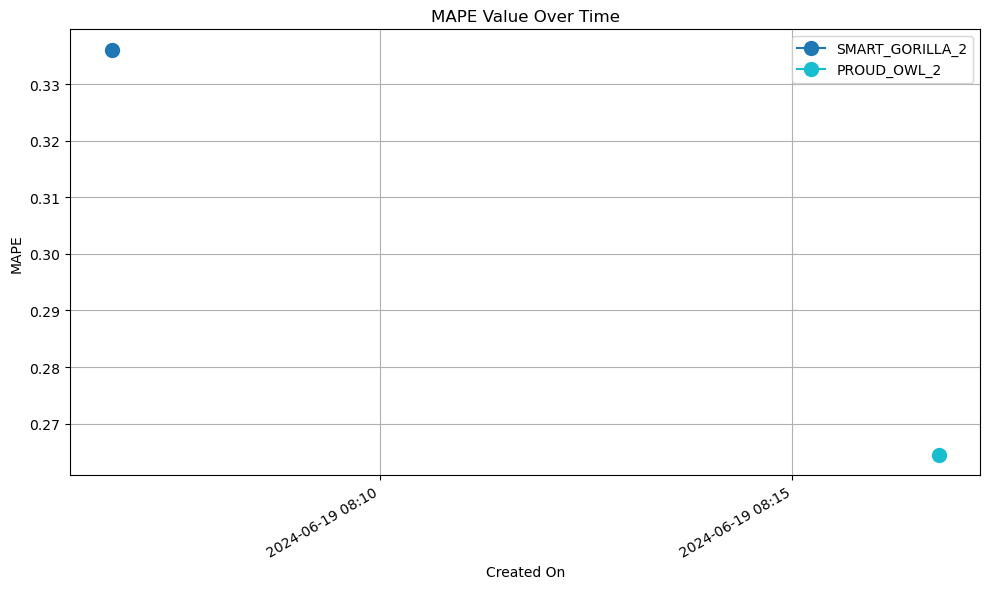

In [53]:
plot_model_metrics(version_metrics)

# 10 - Clean Up

In [ ]:
#ml_wh.delete()
#ml_demo_db.delete()
#session.close()